## (Synchronous) Advantage Actor-Critic cartpole-vo

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import os
import gym


env = gym.make("CartPole-v0")


## Hyper Parameters / 환경에 따라서 바뀜 
STATE_DIM = env.observation_space.shape[0]
ACTION_DIM = env.action_space.n
STEP = 2000
SAMPLE_NUMS = 40
## Network hidden size = 40

episode_durations = []


1.3.1


# Element
* 에이전트(Agent) : Cart
* 환경(Enviornment) : Cart Position,Velocity / Pole Angle , Velocity
* 상태(State) : Cart & Pole Status // 현재 코드에서는 Screen을 통해서 얻음
* 행동(Action)  : Push Cart to the Left or Right
* 정책(Policy) : 네트워크 + Select Action 
    (Input : State / Output : Action Values => Select Action using Action values)
* 보상(Reward) : 각 Step 마다 1점
* 에피소드(Episode) : 폴이 넘어지면 Episode가 끝남 
* 감가율(Discount Factor) : Gamma / 
* 행동 가치(State-Action-Value) : 네트워크를 통해 나온 계산 값
* Exploration method : Random Choice / Trajectory에서 Random하게 Action을 Choice함.
* On - policy :  Critic Network & Actor Network

    
    
# Algorithm
* A2C Algorithm : 아이디어는 여러명에 Agent가 있어서 각각 Agent의 결과를 모아서 학습하자는 아이디어이다. 이때 Advantage Fucntion을 이용하는데 A(s,a) = Q(s,a) - V(s)로 V(s) 는 Baseline이다. 여러개의 Trajectory를 이용해서 학습한다.
* loss 정의 이유 : Actor의 loss는 advantage function을 이용하는데, action의 확률과 advantage의 곱의 평균으로 정의하고, Critic의 loss는 추정한 Value 값과 실제 value 값을 MSE를 이용해 정의한다.
    



In [ ]:
##Actor-Critic 방법에서는 두 개의 네트워크가 필요함.

## NN설정 Actor (Action)
class ActorNetwork(nn.Module):

    def __init__(self,input_size,hidden_size,action_size):
        super(ActorNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size,hidden_size)
        self.fc2 = nn.Linear(hidden_size,hidden_size)
        self.fc3 = nn.Linear(hidden_size,action_size)

    def forward(self,x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        #Action의 값을 확률적으로 표현
        out = F.log_softmax(self.fc3(out),dim=1)
        return out

    
## NN설정 Critic (Value)
class CriticNetwork(nn.Module):

    def __init__(self,input_size,hidden_size,output_size):
        super(CriticNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size,hidden_size)
        self.fc2 = nn.Linear(hidden_size,hidden_size)
        self.fc3 = nn.Linear(hidden_size,output_size)

    def forward(self,x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        #Value값은 하나로 나옴(Output size = 1)
        out = self.fc3(out)
        return out

In [ ]:
## gym Cartpole v-0 환경 수행
## Actor가 최대 Sample_num 만큼 Trajectory를 만든다.
def acting(actor_network,env,sample_nums,critic_network,init_state):
    #env.reset()
    states = []
    actions = []
    rewards = []
    is_done = False
    final_r = 0
    state = init_state
    ##Trajectory
    for j in range(sample_nums):
        
        states.append(state)
        ## Actor network를 통해 Action 값을 확률로 받는다.
        log_softmax_action = actor_network(Variable(torch.Tensor([state])))
        softmax_action = torch.exp(log_softmax_action)
        ## Exploration
        action = np.random.choice(ACTION_DIM,p=softmax_action.cpu().data.numpy()[0])
        ## 이산적인 Action을 저장하기 위해 One Hot Code 사용 
        ## Action 값이 1 또는 0 이어야함.
        one_hot_action = [int(k == action) for k in range(ACTION_DIM)]
        
        next_state,reward,done,_ = env.step(action)
        
        actions.append(one_hot_action)
        rewards.append(reward)
        ## State를 다음 State로 넘어가는 과정.
        final_state = next_state
        state = next_state
        
        if done:
            is_done = True
            ## 끝나면 초기화
            state = env.reset()
            break
    if not is_done:
        ## 마지막 State에서의 reward
        final_r = critic_network(Variable(torch.Tensor([final_state]))).data.numpy()

    return states,actions,rewards,final_r,state

In [ ]:
## 감가율 적용
def discount_reward(r, gamma,final_r):
    discounted_r = np.zeros_like(r)
    running_add = final_r
    ## 감가율을 적용하는데 reward값이 마지막부터 들어가기 때문에 Reversed이용
    for t in reversed(range(0, len(r))):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

In [ ]:
def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # 100개의 에피소드 평균을 가져 와서 도표 그리기
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # 도표가 업데이트되도록 잠시 멈춤

step: 50 test result: 119.9
step: 100 test result: 135.5
step: 150 test result: 193.2
step: 200 test result: 116.2
step: 250 test result: 65.8


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


step: 300 test result: 178.0
step: 350 test result: 200.0
step: 400 test result: 200.0
step: 450 test result: 200.0
step: 500 test result: 200.0
step: 550 test result: 200.0
step: 600 test result: 200.0
step: 650 test result: 200.0
step: 700 test result: 200.0
step: 750 test result: 198.0
step: 800 test result: 200.0
step: 850 test result: 200.0
step: 900 test result: 200.0
step: 950 test result: 200.0
step: 1000 test result: 200.0
step: 1050 test result: 200.0
step: 1100 test result: 200.0
step: 1150 test result: 200.0
step: 1200 test result: 200.0
step: 1250 test result: 29.1
step: 1300 test result: 200.0
step: 1350 test result: 200.0
step: 1400 test result: 200.0
step: 1450 test result: 200.0
step: 1500 test result: 200.0
step: 1550 test result: 200.0
step: 1600 test result: 200.0
step: 1650 test result: 200.0
step: 1700 test result: 200.0
step: 1750 test result: 200.0
step: 1800 test result: 200.0
step: 1850 test result: 200.0
step: 1900 test result: 200.0
step: 1950 test result: 2

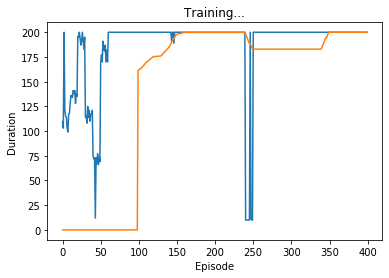

In [2]:
###초기화 부분

## Env.reset()
init_state = env.reset()

## init value network
critic_network = CriticNetwork(input_size = STATE_DIM,hidden_size = 40,output_size = 1)
critic_network_optim = torch.optim.Adam(critic_network.parameters(),lr=0.01)

## init actor network
actor_network = ActorNetwork(STATE_DIM,40,ACTION_DIM)
actor_network_optim = torch.optim.Adam(actor_network.parameters(),lr = 0.01)

steps =[]
env_episodes =[]
test_results =[]
episode_durations = []

## On - policy 이기 때문에 에피소드를 진행하는 Policy를 학습
for step in range(STEP):

    ## Trajectory를 만듬.
    states,actions,rewards,final_r,current_state = acting(actor_network,env,SAMPLE_NUMS,critic_network,init_state)
    
    init_state = current_state
    
    ## Tensor로 바꿔줌
    actions_var = Variable(torch.Tensor(actions).view(-1,ACTION_DIM))
    states_var = Variable(torch.Tensor(states).view(-1,STATE_DIM))

    ## Train actor network
    actor_network_optim.zero_grad()
    log_softmax_actions = actor_network(states_var)
    vs = critic_network(states_var).detach()
    qs = Variable(torch.Tensor(discount_reward(rewards,0.99,final_r)))

    
    ## Adavantage를 이용한 loss 계산 (Adavantage Actor Critic)
    advantages = qs - vs
    actor_network_loss = - torch.mean(torch.sum(log_softmax_actions*actions_var,1)* advantages)
    actor_network_loss.backward()
    
    ## Gradient가 너무 클 경우를 대비해 Clipping gradient 기법을 이용.
    torch.nn.utils.clip_grad_norm_(actor_network.parameters(),0.5)
    actor_network_optim.step()

    ## Train value network
    critic_network_optim.zero_grad()
    target_values = qs
    values = critic_network(states_var)
    criterion = nn.MSELoss()
    critic_network_loss = criterion(values.squeeze(),target_values)
    critic_network_loss.backward()
    
    ## Gradient가 너무 클 경우를 대비해 Clipping gradient 기법을 이용.
    torch.nn.utils.clip_grad_norm_(critic_network.parameters(),0.5)
    critic_network_optim.step()
    
    ## 여기까지 학습

    ## Testing while training
    if (step + 1) % 50== 0:
            result = 0
            test_task = gym.make("CartPole-v0")
            for test_epi in range(10):
                state = test_task.reset()
                ## Test_step의 Range를 변경해도 됨 / Cartpole 학습 기준이 200회.
                for test_step in range(200) :
                    softmax_action = torch.exp(actor_network(Variable(torch.Tensor([state]))))
                    action = np.argmax(softmax_action.data.numpy()[0])
                    next_state,reward,done,_ = test_task.step(action)
                    result += reward
                    state = next_state
                    if done:
                        episode_durations.append(test_step + 1)
                        break
            print("step:",step+1,"test result:",result/10.0)
            steps.append(step+1)
            test_results.append(result/10)
            
            
plot_durations()

In [7]:
## 결과 확인을 위함
def plot_durations1():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(results, dtype=torch.float)
    plt.title('Testing')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.axhline(y=200,linestyle='--')
    plt.plot(durations_t.numpy())
    # 100개의 에피소드 평균을 가져 와서 도표 그리기
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # 도표가 업데이트되도록 잠시 멈춤

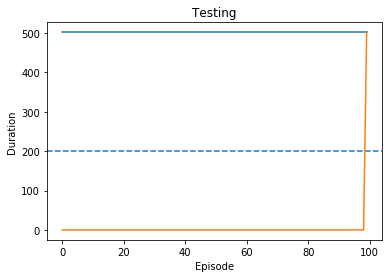

In [11]:
results = []
result = 0
test_task = gym.make("CartPole-v0").unwrapped
i_episodes =0
for i_episodes in range(100):
    state = test_task.reset()
    ## 최대 스텝을 550으로 했지만 unwrapped를 해도 500을 넘어가지 않음.
    for test_step in range(550) :
        softmax_action = torch.exp(actor_network(Variable(torch.Tensor([state]))))
        action = np.argmax(softmax_action.data.numpy()[0])
        next_state,reward,done,_ = test_task.step(action)
        result += reward
        state = next_state
        if done or test_step > 500:
            results.append(test_step + 1)
            break
    steps.append(step+1)
    test_results.append(result/10)
            
plot_durations1()


Comment : 학습 속도도 빠르고, 결과도 좋다. CartPole 환경이다보니 매우 빠르게 수렴했지만 학습 속도가 빠르다는 것을 알 수 있다.